<h1 align='center'> Time Series Forecasting With FBProphet </h1>

## Introduction

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

## Imports

In [30]:
%pip install prophet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
from prophet import Prophet 
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation


## Load the Data

In [32]:
df = pd.read_csv("data/RestaurantVisitors.csv", infer_datetime_format=True, index_col='date', parse_dates=True)

df.head()

/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_59029/638171679.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("data/RestaurantVisitors.csv", infer_datetime_format=True, index_col='date', parse_dates=True)


,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [33]:
df.index.min(), df.index.max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2017-05-31 00:00:00'))

In [34]:
#drop rows where total is null
df = df.dropna()

## Univariate Forecasting

### Data Preparation

In [35]:
# Preparing the data
uni_data = df.reset_index()[['date', 'total']]
uni_data = uni_data.rename(columns={'date': 'ds', 'total': 'y'})

uni_data.head()

,ds,y
0,2016-01-01,296.0
1,2016-01-02,191.0
2,2016-01-03,202.0
3,2016-01-04,105.0
4,2016-01-05,98.0


### Train/Valid Data Split

In [36]:
# Splitting the data into training and validation sets
split_date = '2017-01-01' 
train = uni_data[uni_data['ds'] < split_date]
test = uni_data[uni_data['ds'] >= split_date]

print(f"train shape : {train.shape} and test shape : {test.shape}")


train shape : (366, 2) and test shape : (112, 2)


### Model's Training

In [37]:
# Training the model
uni_model = Prophet()
uni_model.fit(train)

14:32:29 - cmdstanpy - INFO - Chain [1] start processing
14:32:29 - cmdstanpy - INFO - Chain [1] done processing


### Inference

In [38]:
# Making predictions on the validation set
future_uni = uni_model.make_future_dataframe(periods=len(test))
forecast_uni = uni_model.predict(future_uni)


In [39]:
forecast_uni.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01,144.108324,119.245160,202.687580,144.108324,144.108324,16.144524,16.144524,16.144524,16.144524,16.144524,16.144524,0.0,0.0,0.0,160.252848
1,2016-01-02,144.026058,197.251071,279.251152,144.026058,144.026058,94.044348,94.044348,94.044348,94.044348,94.044348,94.044348,0.0,0.0,0.0,238.070405
2,2016-01-03,143.943792,148.173606,228.180537,143.943792,143.943792,46.631034,46.631034,46.631034,46.631034,46.631034,46.631034,0.0,0.0,0.0,190.574825
3,2016-01-04,143.861525,62.102015,143.563866,143.861525,143.861525,-43.995607,-43.995607,-43.995607,-43.995607,-43.995607,-43.995607,0.0,0.0,0.0,99.865918
4,2016-01-05,143.779259,61.271200,141.530261,143.779259,143.779259,-41.595880,-41.595880,-41.595880,-41.595880,-41.595880,-41.595880,0.0,0.0,0.0,102.183379


### Model Evaluation

In [40]:
test.columns

Index(['ds', 'y'], dtype='object')

In [41]:
y_pred_df_uni = forecast_uni[forecast_uni['ds'] >= split_date][['ds', 'yhat']]

result = pd.merge(test, y_pred_df_uni, how='inner')

result.shape

(112, 3)

In [42]:
result.head()

,ds,y,yhat
0,2017-01-01,256.0,187.109643
1,2017-01-02,130.0,96.603769
2,2017-01-03,144.0,99.124263
3,2017-01-04,99.0,101.528272
4,2017-01-05,75.0,109.045899


In [43]:
#calculate rmse and mae
rmse = np.sqrt(np.mean((result['y']-result['yhat'])**2))
mae = (np.mean(np.abs(result['y']-result['yhat'])))

print(f"RMSE from Univariate Analysis is : {rmse}")
print(f"MAE from Univariate Analysis is : {mae}")

RMSE from Univariate Analysis is : 34.689431596064665
MAE from Univariate Analysis is : 28.046783201990444


### Plot

<Axes: xlabel='ds'>

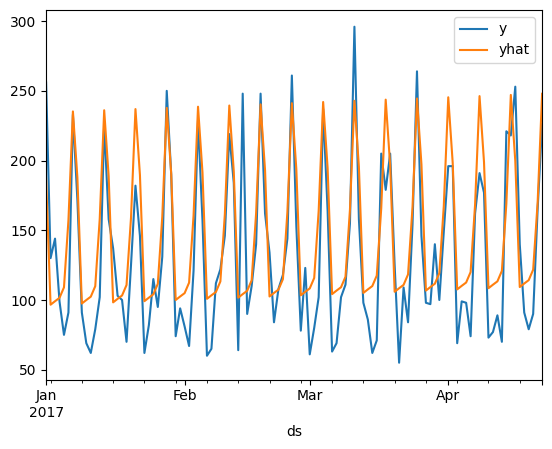

In [44]:
result.set_index('ds').plot()

In [45]:
#save the metrics values
perf_df = pd.DataFrame({"model": ["Univariate"], "RMSE": [rmse], "MAE": [mae]})
perf_df.head()

,model,RMSE,MAE
0,Univariate,34.689432,28.046783


## Multivariate Forecasting

### Data preparation

In [46]:
# Preparing the data for multivariate time series analysis
# Convert 'weekday' and 'holiday_name' to categorical variables using get dummies
df = df.reset_index()
df['weekday'] = pd.Categorical(df['weekday'])
weekday_dummies = pd.get_dummies(df['weekday'], prefix='weekday')
holiday_name_dummies = pd.get_dummies(df['holiday_name'], prefix='holiday_name')

multi_data = pd.concat([df[['date', 'total', 'holiday']], weekday_dummies, holiday_name_dummies], axis=1)
multi_data = multi_data.rename(columns={'date': 'ds', 'total': 'y'})

multi_data.head()


,ds,y,holiday,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,...,holiday_name_Memorial Day,holiday_name_Mother's Day,holiday_name_New Year's Day,holiday_name_New Year's Eve,holiday_name_Presidents Day,holiday_name_St. Patrick's Day,holiday_name_Thanksgiving,holiday_name_Valentine's Day,holiday_name_Veterans' Day,holiday_name_na
0,2016-01-01,296.0,1,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,2016-01-02,191.0,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2016-01-03,202.0,0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2016-01-04,105.0,0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,2016-01-05,98.0,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


### Train/Validation Split

In [47]:
# Splitting the data into training and validation sets
split_date = '2017-01-01'  # replace with the date where you want to split the data
train = multi_data[multi_data['ds'] < split_date]
test = multi_data[multi_data['ds'] >= split_date]


### Model's Training

In [48]:
multi_data.columns

Index(['ds', 'y', 'holiday', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'holiday_name_Black Friday',
       'holiday_name_Christmas Day', 'holiday_name_Christmas Eve',
       'holiday_name_Cinco de Mayo', 'holiday_name_Columbus Day',
       'holiday_name_Easter', 'holiday_name_Easter Monday',
       'holiday_name_Father's Day', 'holiday_name_Good Friday',
       'holiday_name_Groundhog Day', 'holiday_name_Halloween',
       'holiday_name_Independence Day', 'holiday_name_Labor Day',
       'holiday_name_Martin Luther King Day', 'holiday_name_Memorial Day',
       'holiday_name_Mother's Day', 'holiday_name_New Year's Day',
       'holiday_name_New Year's Eve', 'holiday_name_Presidents Day',
       'holiday_name_St. Patrick's Day', 'holiday_name_Thanksgiving',
       'holiday_name_Valentine's Day', 'holiday_name_Veterans' Day',
       'holiday_name_na'],
      dtype='object')

In [49]:
# Initializing the Prophet model for multivariate analysis
multi_model = Prophet()

# Adding the additional regressors
for column in multi_data.columns[2:]:
    print(column)
    multi_model.add_regressor(column)

holiday
weekday_Friday
weekday_Monday
weekday_Saturday
weekday_Sunday
weekday_Thursday
weekday_Tuesday
weekday_Wednesday
holiday_name_Black Friday
holiday_name_Christmas Day
holiday_name_Christmas Eve
holiday_name_Cinco de Mayo
holiday_name_Columbus Day
holiday_name_Easter
holiday_name_Easter Monday
holiday_name_Father's Day
holiday_name_Good Friday
holiday_name_Groundhog Day
holiday_name_Halloween
holiday_name_Independence Day
holiday_name_Labor Day
holiday_name_Martin Luther King Day
holiday_name_Memorial Day
holiday_name_Mother's Day
holiday_name_New Year's Day
holiday_name_New Year's Eve
holiday_name_Presidents Day
holiday_name_St. Patrick's Day
holiday_name_Thanksgiving
holiday_name_Valentine's Day
holiday_name_Veterans' Day
holiday_name_na


In [50]:
# Fit the model
multi_model.fit(train)

14:32:30 - cmdstanpy - INFO - Chain [1] start processing
14:32:30 - cmdstanpy - INFO - Chain [1] done processing


### Inference

In [51]:
train.head()

,ds,y,holiday,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,...,holiday_name_Memorial Day,holiday_name_Mother's Day,holiday_name_New Year's Day,holiday_name_New Year's Eve,holiday_name_Presidents Day,holiday_name_St. Patrick's Day,holiday_name_Thanksgiving,holiday_name_Valentine's Day,holiday_name_Veterans' Day,holiday_name_na
0,2016-01-01,296.0,1,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,2016-01-02,191.0,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2016-01-03,202.0,0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2016-01-04,105.0,0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,2016-01-05,98.0,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


In [52]:
test.head()

,ds,y,holiday,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,...,holiday_name_Memorial Day,holiday_name_Mother's Day,holiday_name_New Year's Day,holiday_name_New Year's Eve,holiday_name_Presidents Day,holiday_name_St. Patrick's Day,holiday_name_Thanksgiving,holiday_name_Valentine's Day,holiday_name_Veterans' Day,holiday_name_na
366,2017-01-01,256.0,1,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
367,2017-01-02,130.0,0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
368,2017-01-03,144.0,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
369,2017-01-04,99.0,0,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
370,2017-01-05,75.0,0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [53]:
multi_data.head()

,ds,y,holiday,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,...,holiday_name_Memorial Day,holiday_name_Mother's Day,holiday_name_New Year's Day,holiday_name_New Year's Eve,holiday_name_Presidents Day,holiday_name_St. Patrick's Day,holiday_name_Thanksgiving,holiday_name_Valentine's Day,holiday_name_Veterans' Day,holiday_name_na
0,2016-01-01,296.0,1,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,2016-01-02,191.0,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2016-01-03,202.0,0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2016-01-04,105.0,0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,2016-01-05,98.0,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


In [54]:
# Making predictions on the validation set
future_multi = multi_model.make_future_dataframe(periods=len(test))

#add all the additional columns to future_multi
future_multi = pd.merge(future_multi, multi_data.drop("y", axis=1),how='left', on='ds')

forecast_multi = multi_model.predict(future_multi)

forecast_multi.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekday_Wednesday,weekday_Wednesday_lower,weekday_Wednesday_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01,221.481240,265.901872,331.335487,221.481240,221.481240,76.102743,76.102743,76.102743,66.442824,...,0.0,0.0,0.0,9.659919,9.659919,9.659919,0.0,0.0,0.0,297.583983
1,2016-01-02,221.402258,201.317809,267.481313,221.402258,221.402258,13.757043,13.757043,13.757043,-60.963289,...,0.0,0.0,0.0,74.720332,74.720332,74.720332,0.0,0.0,0.0,235.159302
2,2016-01-03,221.323277,151.393483,215.622079,221.323277,221.323277,-36.773001,-36.773001,-36.773001,-72.192191,...,0.0,0.0,0.0,35.419190,35.419190,35.419190,0.0,0.0,0.0,184.550276
3,2016-01-04,221.244295,56.561232,121.480157,221.244295,221.244295,-133.505513,-133.505513,-133.505513,-93.688312,...,0.0,0.0,0.0,-39.817201,-39.817201,-39.817201,0.0,0.0,0.0,87.738782
4,2016-01-05,221.165313,66.951290,133.793892,221.165313,221.165313,-119.566013,-119.566013,-119.566013,-90.590627,...,0.0,0.0,0.0,-28.975386,-28.975386,-28.975386,0.0,0.0,0.0,101.599300


### Model's Evaluation

In [56]:
 test.shape

(112, 34)

In [57]:
y_pred_df_multi = forecast_multi[forecast_multi['ds'] >= split_date][['ds', 'yhat']]

result = pd.merge(test[['ds', 'y']], y_pred_df_multi, how='inner')

result.head()

,ds,y,yhat
0,2017-01-01,256.0,326.724844
1,2017-01-02,130.0,84.100797
2,2017-01-03,144.0,98.143573
3,2017-01-04,99.0,100.526273
4,2017-01-05,75.0,104.998564


In [58]:
#calculate rmse
rmse = np.sqrt(np.mean((result['y']-result['yhat'])**2))
mae = (np.mean(np.abs(result['y']-result['yhat'])))

print(f"RMSE from Multivariate Analysis is : {rmse}")
print(f"MAE from Multivariate Analysis is : {mae}")

RMSE from Multivariate Analysis is : 29.831951083657653
MAE from Multivariate Analysis is : 23.64276725517515


In [59]:
perf_df = pd.concat([perf_df, pd.DataFrame({"model":["Multivariate"], "RMSE":[rmse], "MAE":[mae]})])
perf_df.head()

,model,RMSE,MAE
0,Univariate,34.689432,28.046783
0,Multivariate,29.831951,23.642767


<Axes: xlabel='ds'>

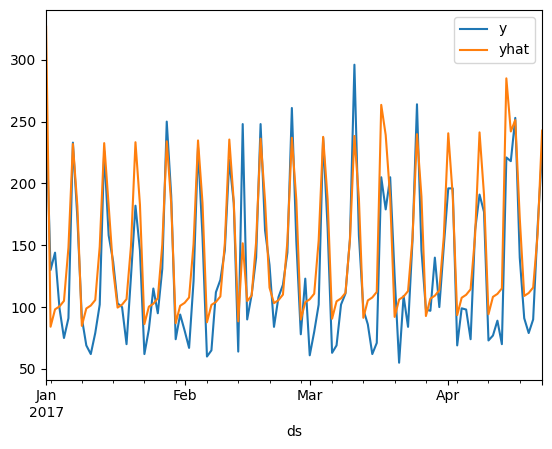

In [60]:
result.set_index('ds').dropna().plot()

**It seems like multivariate analysis is performing better than the univariate analysis of visitors count!**

## Univariate vs Multivariate Modeling

### Error Analysis

<Axes: xlabel='model'>

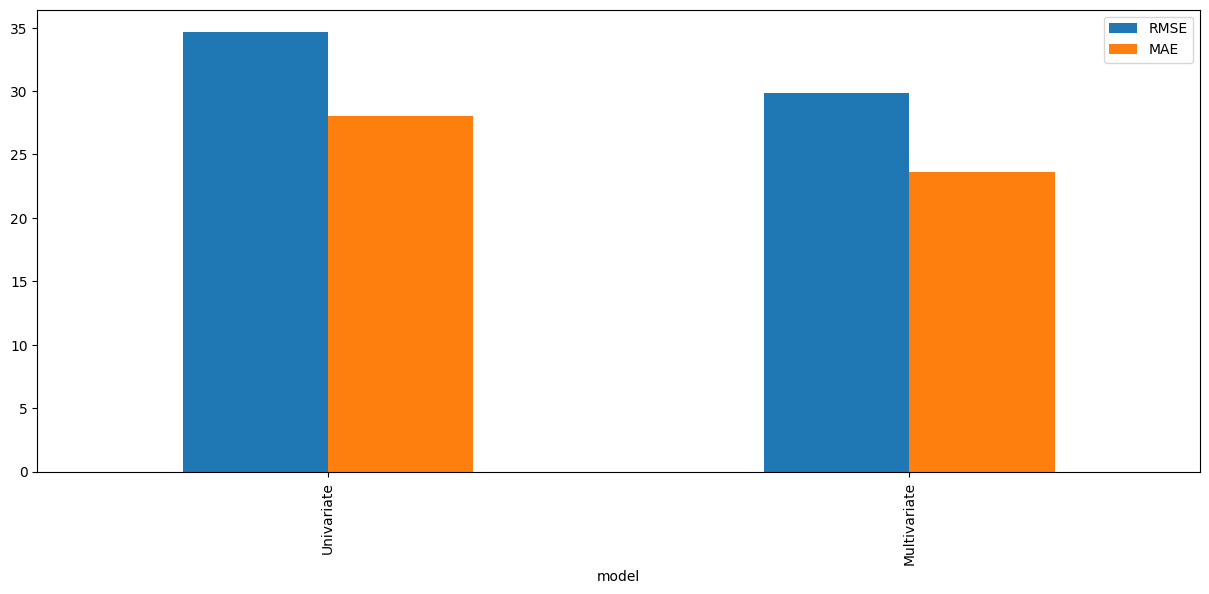

In [61]:
perf_df.set_index("model").plot(kind='bar', figsize=(15, 6))

On both count Root Mean Squared Error(RMSE) and Mean Absolute Error(MAE) Multivariate Prophet performing better than the univariate counterpart.

### Prediction Analysis

In [62]:
y = test[['ds', 'y']].rename({"ds":"date", "y":"Actual"}, axis=1)
y_pred_df_multi = y_pred_df_multi.rename({"ds":"date", "yhat":"Multivariate Prediction"}, axis=1)
y_pred_df_uni = y_pred_df_uni.rename({"ds":"date", "yhat":"Univariate Prediction"}, axis=1)

plot_df = pd.merge(y_pred_df_multi, y, on=["date"], how="inner")
plot_df = pd.merge(plot_df, y_pred_df_uni, on=["date"], how="inner").set_index("date")

plot_df.head()

,Multivariate Prediction,Actual,Univariate Prediction
date,,,
2017-01-01,326.724844,256.0,187.109643
2017-01-02,84.100797,130.0,96.603769
2017-01-03,98.143573,144.0,99.124263
2017-01-04,100.526273,99.0,101.528272
2017-01-05,104.998564,75.0,109.045899


<Axes: xlabel='date'>

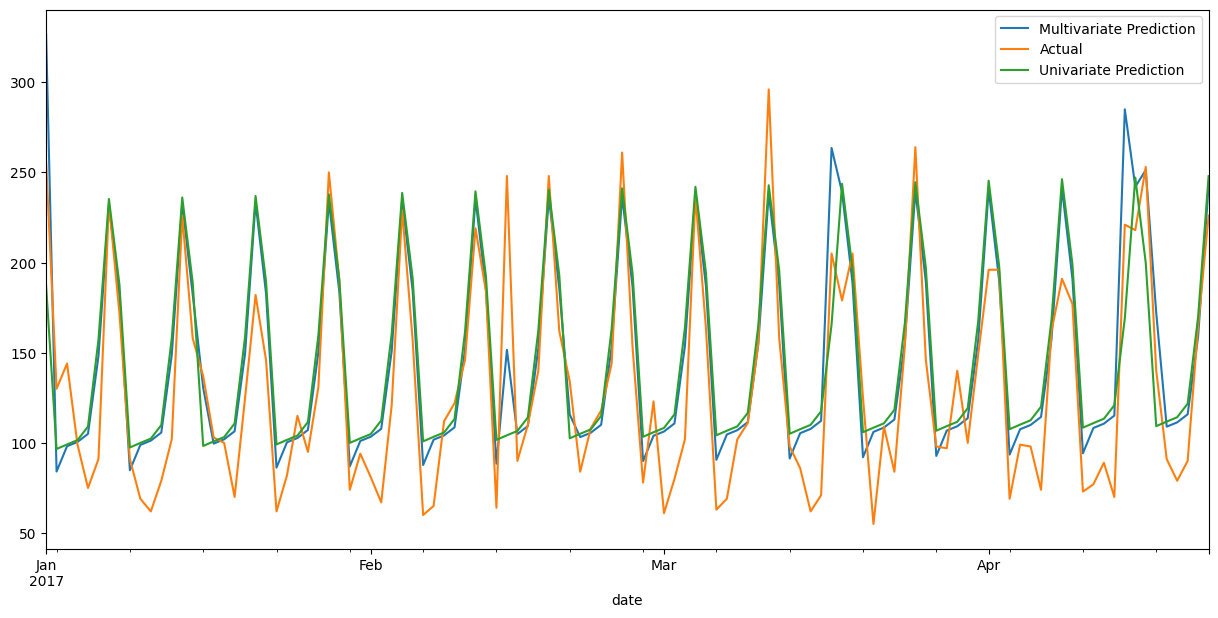

In [63]:
plot_df.plot(figsize=(15, 7))

Clearly, Multivariate Analysis has upper edge in capturing the nuances of the variation in actual values over time.